#### Measurement Framework Library
# MFLib API Examples: Accessing ELK Logs & Metrics


## Prerequisites
The slice has to have already been instrumentized. See the [Instrumentize a Slice](./instrumentize_a_slice.ipynb) notebook.

## General Imports

In [ ]:
import os
import json
import traceback

## Import MFLib

In [ ]:
# If you installed the fabrictestbed_extensions you can use:
from fabrictestbed_extensions.mflib.mflib import mflib
# If you are using a local copy of the mflib.py file use:
#from mflib import mflib

## Set Experiment Slice Name

#### If you are using the slice created in the Instrumentize a Slice notebook, you will have this instrumentized topology and slice name.

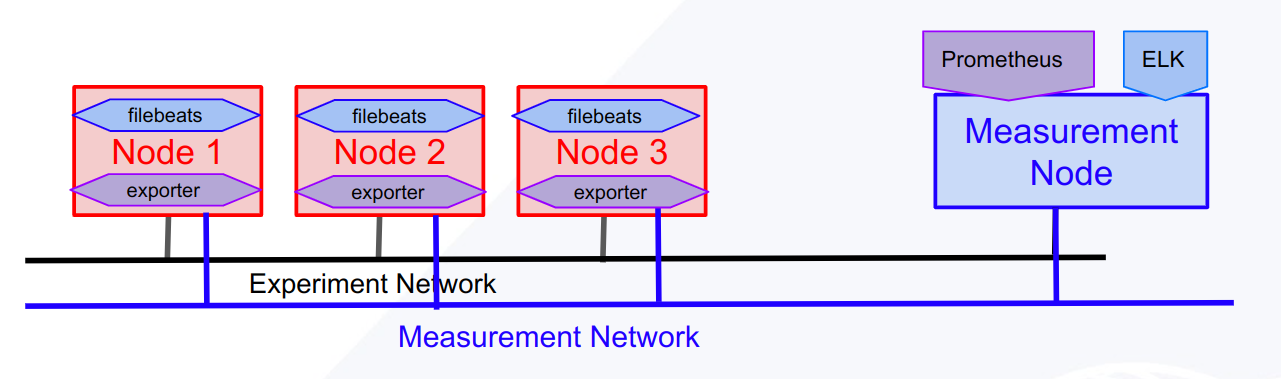

In [ ]:
# The slice name of the slice with which you want to interact.
slice_name = "MyMonitoredSlice"

## Create the MFLib Object
Create the new MFLib object by passing in the name of the slice with which you will be interacting.
This will take a few seconds. 
Note: If the slice has not been previously initialized and instrumentized then this step will attempt to initialize the slice. That will take ~ 5 minutes. However, as of this writing, if the slice is not instrumentized, instrumentize will not be performed.

In [ ]:
mf = mflib(slice_name)

# ELK

Elk consists of 3 basic parts:
* Elastic Search database running on the Measurement Node.
* Filebeats have been installed on the experiment nodes to push data to Elastic Search.
* Kibana has been installed on the Measurement Node and provides a web GUI to visualize the gathered metrics and logs.


## Get Kibana Access Info
To access the ELK data go to the Kibana interface.   
From your local machine, you will have to tunnel through the bastion host into the measurement node. 
If you have added FABRIC_ALT_COPY_SSH_CONFIG and FABRIC_ALT_COPY_SLICE_PRIVATE_KEY_FILE to your fabric_rc file use `mf.kibana_tunnel` to get the SSH tunnel command. 

Otherwise you will need to create the tunnel using:   
`ssh -L 10020:localhost:80 -F <fabric-ssh-config-file> -i <your portal_slice_id_rsa-file> <slice-username>@<meas_node-ip>`   


In [ ]:
# ELK SSH Tunnel Command
# mf.grafana_tunnel_local_port = 10020 # optionally change the port
print(mf.kibana_tunnel)

Browse to [http://localhost:10020](http://localhost:10020) or  for dashboard listing browse to [http://localhost:10020/app/dashboards](http://localhost:10020/app/dashboards)
You will need to type in the ht_access username and password. See below.

In [ ]:
# The ELK service was created by the mf.instrumentize call.
# Get access info for Kibana by using the mflib.info call to the elk service.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["nginx_id", "nginx_password"]
# Call info using service name and data dictionary.
info_results = mf.info("elk", data)
print(info_results)

if info_results["success"]:
    print(f"user: {info_results['nginx_id']} \npass: {info_results['nginx_password']}")

In [ ]:
# A few direct links to node data 
for node in mf.slice.get_nodes():
    if node.get_name() !=  "_meas_node":
        print(f"{node.get_name()} ELK Metric Overview")
        print(f"    http://localhost:10020/app/metrics/detail/host/{node.get_reservation_id()}-{node.get_name().lower()}")

### Upload Custom Kibana Dashboards

Upload a single dashboard.

In [ ]:
data = {}
data["commands"] = []

# Add upload_dashboards command along with dashboard filenames to upload.
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":["FABRICDashboards.ndjson"]} )

# Add add_dashboards command along with dashboard filenames to add.
data["commands"].append({"cmd":"add_dashboards", "dashboard_filenames":["FABRICDashboards.ndjson"] } )

# Add list of files to upload to the Measurement Node.
files = ["./dashboard_examples/kibana/FABRICDashboards.ndjson"]

# Call update
results = mf.update("elk", data, files)
print(results)

Upload a directory of dashboards.

In [ ]:
# Array to be filled with full paths of all dashboard files in dashboards_folder directory
dashboard_filenames = [] 
dashboards_folder = "./dashboard_examples/kibana/"

# Loop through dashboards folder
for file in os.listdir(dashboards_folder):
    # Only upload dashboard files 
    if file.endswith(".ndjson"): 
        # Add full path of dashboard to array
        dashboard_filenames.append(os.path.join(dashboards_folder, file)) 

# Build update command.
data = {}
data["commands"] = []

# Add upload_dashboards command along with dashboard filenames to upload.
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":dashboard_filenames})

# Add add_dashboards command along with dashboard filenames to add.
data["commands"].append( {"cmd":"add_dashboards", "dashboard_filenames":dashboard_filenames})

# Call update
dashboard_results = mf.update("elk", data, dashboard_filenames)
print(dashboard_results)